# Lab: Survival Analysis

In this lab, we perform survival analyses on three separate data sets. In Section 11.8.1 we analyze the `BrainCancer` data that was  first described in Section 11.3.
 In Section 11.8.2, we examine the `Publication` data from Section 11.5.4. Finally, Section 11.8.3 explores a simulated call center data set.

## Brain Cancer Data
We begin with the `BrainCancer` data set, which is part of the  `ISLR2` package.

In [1]:
library(ISLR2)

The rows index the 88 patients, while the columns contain the 8 predictors.

In [2]:
names(BrainCancer)

[1] "sex"       "diagnosis" "loc"       "ki"        "gtv"       "stereo"   
[7] "status"    "time"

We first briefly examine the data.

In [3]:
attach(BrainCancer)
table(sex)
table(diagnosis)
table(status)

sex
Female   Male 
    45     43 

diagnosis
Meningioma  LG glioma  HG glioma      Other 
        42          9         22         14 

status
 0  1 
53 35 

Before beginning an analysis, it is important to know how the `status` variable has been coded.  Most software, including `R`, uses the convention that `status = 1` indicates an uncensored observation,  and `status = 0` indicates a censored observation. But some scientists might use the opposite coding. For the `BrainCancer` data set $35$ patients died before the end of the study.

To begin the analysis, we re-create  the Kaplan-Meier survival curve  shown in  Figure 11.2, using the `survfit()` function within the `R` `survival` library. Here `time` corresponds to $y_i$, the time to the $i$th event (either censoring or death).

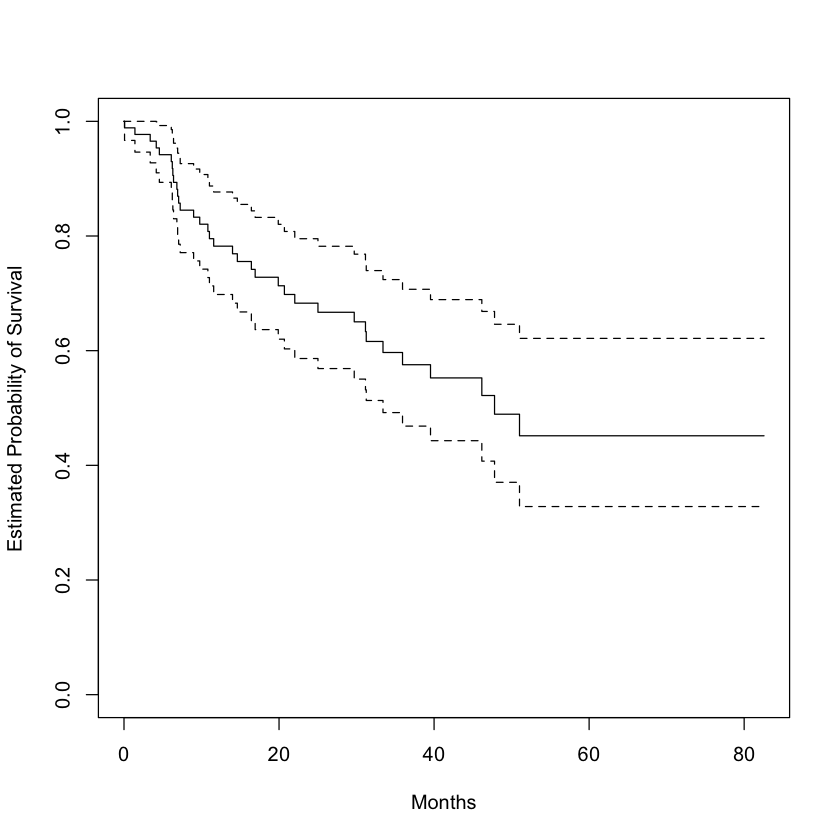

In [4]:
library(survival)
fit.surv <- survfit(Surv(time, status) ~ 1)
plot(fit.surv, xlab = "Months",
    ylab = "Estimated Probability of Survival")

Next we create Kaplan-Meier survival curves that are stratified by `sex`, in order to reproduce Figure 11.3.

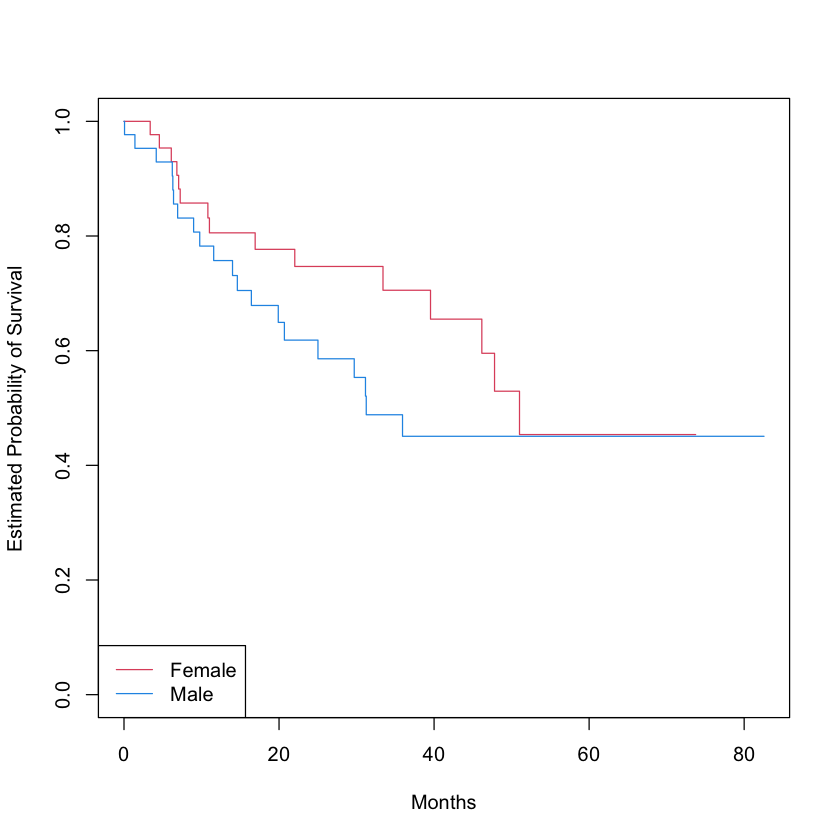

In [5]:
fit.sex <- survfit(Surv(time, status) ~ sex)
plot(fit.sex, xlab = "Months",
    ylab = "Estimated Probability of Survival", col = c(2,4))
legend("bottomleft", levels(sex), col = c(2,4), lty = 1)

As discussed in Section 11.4, we can perform a log-rank test to compare the survival of males to females, using the `survdiff()` function.

In [6]:
logrank.test <- survdiff(Surv(time, status) ~ sex)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ sex)

            N Observed Expected (O-E)^2/E (O-E)^2/V
sex=Female 45       15     18.5     0.676      1.44
sex=Male   43       20     16.5     0.761      1.44

 Chisq= 1.4  on 1 degrees of freedom, p= 0.2 

The resulting $p$-value is $0.23$, indicating  no evidence of a difference in survival between the two sexes.

Next, we fit  Cox proportional hazards models using the `coxph()`  function.
To begin, we consider a model that uses `sex` as the only predictor.

In [7]:
fit.cox <- coxph(Surv(time, status) ~ sex)
summary(fit.cox)

Call:
coxph(formula = Surv(time, status) ~ sex)

  n= 88, number of events= 35 

          coef exp(coef) se(coef)     z Pr(>|z|)
sexMale 0.4077    1.5033   0.3420 1.192    0.233

        exp(coef) exp(-coef) lower .95 upper .95
sexMale     1.503     0.6652     0.769     2.939

Concordance= 0.565  (se = 0.045 )
Likelihood ratio test= 1.44  on 1 df,   p=0.2
Wald test            = 1.42  on 1 df,   p=0.2
Score (logrank) test = 1.44  on 1 df,   p=0.2


Note that the values of the likelihood ratio, Wald, and score tests have been rounded.  It is possible to display additional digits.

In [8]:
summary(fit.cox)$logtest[1]
summary(fit.cox)$waldtest[1]
summary(fit.cox)$sctest[1]

test 
1.438822

test 
1.42

test 
1.440495

Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females.

In [9]:
logrank.test$chisq

[1] 1.440495

As we learned in this chapter, the score test from the Cox model is exactly equal to the log rank test statistic!

Now we fit a  model that makes use of additional predictors. 

In [10]:
fit.all <- coxph(
Surv(time, status) ~ sex + diagnosis + loc + ki + gtv +
   stereo)
fit.all

Call:
coxph(formula = Surv(time, status) ~ sex + diagnosis + loc + 
    ki + gtv + stereo)

                       coef exp(coef) se(coef)      z        p
sexMale             0.18375   1.20171  0.36036  0.510  0.61012
diagnosisLG glioma  0.91502   2.49683  0.63816  1.434  0.15161
diagnosisHG glioma  2.15457   8.62414  0.45052  4.782 1.73e-06
diagnosisOther      0.88570   2.42467  0.65787  1.346  0.17821
locSupratentorial   0.44119   1.55456  0.70367  0.627  0.53066
ki                 -0.05496   0.94653  0.01831 -3.001  0.00269
gtv                 0.03429   1.03489  0.02233  1.536  0.12466
stereoSRT           0.17778   1.19456  0.60158  0.296  0.76760

Likelihood ratio test=41.37  on 8 df, p=1.776e-06
n= 87, number of events= 35 
   (1 observation deleted due to missingness)

The `diagnosis` variable has been coded so that the baseline
corresponds to meningioma. The results indicate that the risk associated with HG glioma is more than eight times (i.e. $e^{2.15}=8.62$) the risk associated with meningioma. In other words, after adjusting for the other predictors, patients with HG glioma have much worse survival
compared to those with meningioma.  In addition, larger values of the Karnofsky index, `ki`, are associated with lower risk, i.e. longer survival.

Finally, we plot survival curves for each diagnosis category,  adjusting for the other predictors.
To make these plots, we set the values of the other predictors equal
to the mean for quantitative variables, and the modal value for
factors. We first create a data frame with four rows, one for each
level of diagnosis. The `survfit()` function will produce a curve for each of the rows in this data frame,
and one call to `plot()` will display them all in the same plot.


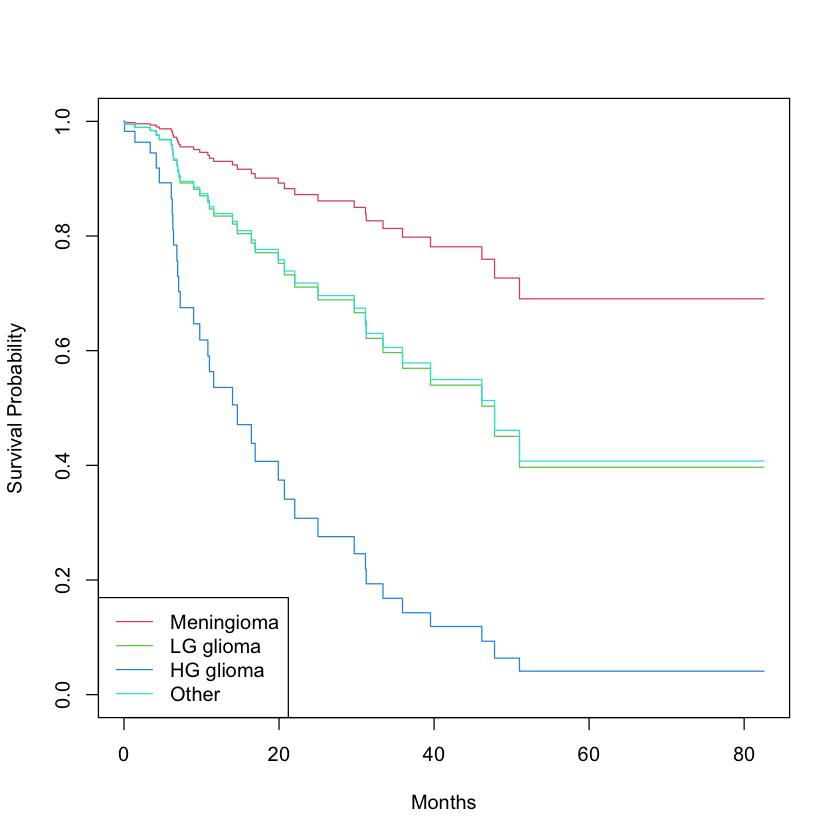

In [11]:
modaldata <- data.frame(
     diagnosis = levels(diagnosis),
     sex = rep("Female", 4),
     loc = rep("Supratentorial", 4),
     ki = rep(mean(ki), 4),
     gtv = rep(mean(gtv), 4),
     stereo = rep("SRT", 4)
     )
survplots <- survfit(fit.all, newdata = modaldata)
plot(survplots, xlab = "Months",
    ylab = "Survival Probability", col = 2:5)
legend("bottomleft", levels(diagnosis), col = 2:5, lty = 1)

## Publication Data


\normalsize

The `Publication` data presented in Section 11.5.4 can be found in the `ISLR2` library. We first reproduce Figure 11.5 by plotting the Kaplan-Meier curves stratified on the `posres` variable, which records whether the study had a positive or negative result.

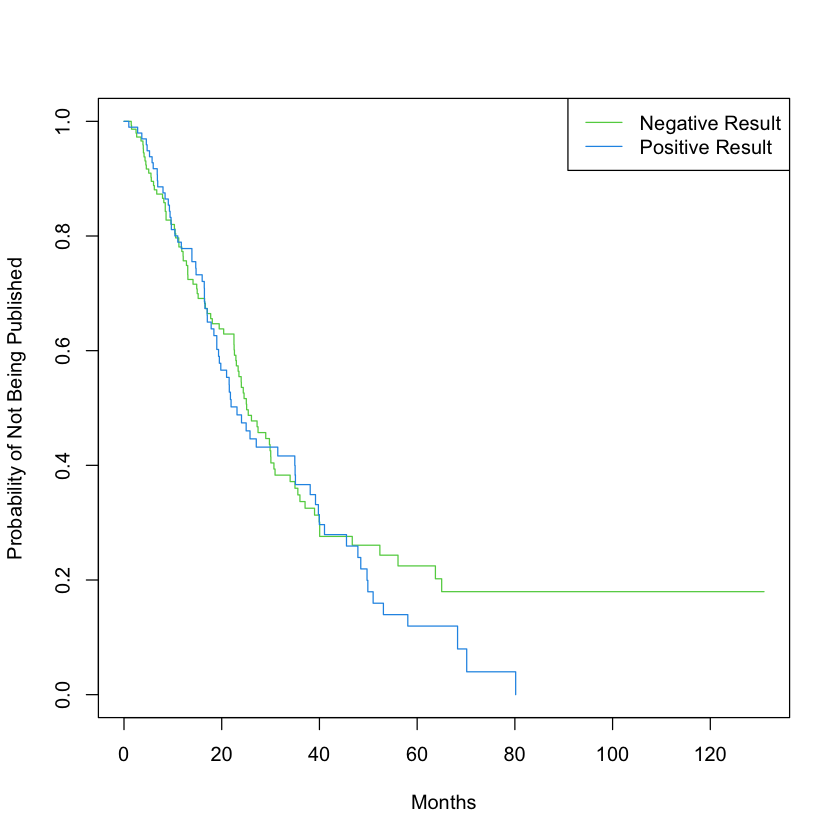

In [12]:
fit.posres <- survfit(
    Surv(time, status) ~ posres, data = Publication
  )
plot(fit.posres, xlab = "Months",
    ylab = "Probability of Not Being Published", col = 3:4)
legend("topright", c("Negative Result", "Positive Result"),
    col = 3:4, lty = 1)

As discussed previously, the $p$-values from fitting Cox's proportional hazards model to the `posres` variable are quite large, providing no evidence of a difference in time-to-publication between studies with positive versus negative results.

In [13]:
fit.pub <- coxph(Surv(time, status) ~ posres,
    data = Publication)
fit.pub

Call:
coxph(formula = Surv(time, status) ~ posres, data = Publication)

         coef exp(coef) se(coef)     z    p
posres 0.1481    1.1596   0.1616 0.916 0.36

Likelihood ratio test=0.83  on 1 df, p=0.3611
n= 244, number of events= 156 

As expected, the log-rank test provides an identical conclusion.

In [14]:
logrank.test <- survdiff(Surv(time, status) ~ posres,
    data = Publication)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ posres, data = Publication)

           N Observed Expected (O-E)^2/E (O-E)^2/V
posres=0 146       87     92.6     0.341     0.844
posres=1  98       69     63.4     0.498     0.844

 Chisq= 0.8  on 1 degrees of freedom, p= 0.4 

However, the results change dramatically when we include other  predictors in the model. Here we have excluded the funding mechanism variable.

In [15]:
fit.pub2 <- coxph(Surv(time, status) ~ . - mech,
    data = Publication)
fit.pub2

Call:
coxph(formula = Surv(time, status) ~ . - mech, data = Publication)

               coef  exp(coef)   se(coef)      z       p
posres    5.708e-01  1.770e+00  1.760e-01  3.244 0.00118
multi    -4.086e-02  9.600e-01  2.512e-01 -0.163 0.87079
clinend   5.462e-01  1.727e+00  2.620e-01  2.085 0.03710
sampsize  4.678e-06  1.000e+00  1.472e-05  0.318 0.75070
budget    4.385e-03  1.004e+00  2.465e-03  1.779 0.07518
impact    5.832e-02  1.060e+00  6.676e-03  8.735 < 2e-16

Likelihood ratio test=149.2  on 6 df, p=< 2.2e-16
n= 244, number of events= 156 

We see that there are a number of  statistically significant variables, including whether the trial focused on a clinical endpoint, the impact of the study, and whether the study had positive or negative results.

## Call Center Data

In this section, we will simulate survival data using the `sim.survdata()` function, which is part of the `coxed` library. Our simulated data will represent the observed wait times (in seconds) for 2,000 customers who have phoned  a call center.
In this context, censoring occurs if a customer hangs up before his or her call is answered.

There are three covariates: `Operators` (the number of call center operators available at the time of the call, which can range from $5$ to $15$), `Center` (either A, B, or C), and `Time` of day (Morning, Afternoon, or Evening). We generate data for these covariates so that all possibilities are equally likely: for instance, morning, afternoon and evening calls are equally likely, and any number of operators from $5$ to $15$ is equally likely.

In [16]:
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X <- model.matrix( ~ Operators + Center + Time)[, -1]

It is worthwhile to take a peek at the design matrix `X`},  so that we can be sure that we understand how the
variables have been coded.

In [17]:
X[1:5, ]

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.
1,12,1,0,0,1
2,15,0,0,0,0
3,7,0,1,1,0
4,7,0,0,0,0
5,11,0,1,0,1


Next,  we specify the coefficients and the hazard function.

In [18]:
true.beta <- c(0.04, -0.3, 0, 0.2, -0.2)
h.fn <- function(x) return(0.00001 * x)

Here, we have set the coefficient associated with `Operators` to equal $0.04$; in other words, each additional operator leads to a $e^{0.04}=1.041$-fold increase in the
  "risk" that the call will be answered,
given the `Center` and `Time` covariates. This makes sense: the greater the number of operators at hand, the shorter the wait time! The coefficient associated with `Center = B`
is $-0.3$, and `Center = A` is treated as the baseline. This means that the risk of a call being
answered at Center B is $0.74$ times the risk that it will be answered at Center A; in other words,
the wait times are a bit longer at Center B.

We are now ready to  generate data under the  Cox proportional hazards model. The `sim.survdata()` function allows us to specify the maximum possible failure time, which in this case corresponds to the longest possible wait time for a customer; we set this to equal $1{,}000$ seconds.

In [19]:
library(coxed)
queuing <- sim.survdata(N = N, T = 1000, X = X,
    beta = true.beta, hazard.fun = h.fn)
names(queuing)

Loading required package: rms

Loading required package: Hmisc

Loading required package: lattice

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-34. For overview type 'help("mgcv-package")'.

Warning message in FUN(X[[i]], ...):
“9 additional observations right-censored because the user-supplied hazard function
                                  is nonzero at the latest timepoint. To avoid these extra censored observations, increase T”


[1] "data"             "xdata"            "baseline"         "xb"              
[5] "exp.xb"           "betas"            "ind.survive"      "marg.effect"     
[9] "marg.effect.data"

The "observed" data is stored in `queuing$data`, with `y` corresponding to the event time and `failed` an indicator of whether the call was answered (`failed = T`) or the customer hung up before the call was answered (`failed = F`). We see that almost $90\%$ of calls were answered.

In [20]:
head(queuing$data)
mean(queuing$data$failed)

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,12,1,0,0,1,344,TRUE
2,15,0,0,0,0,241,TRUE
3,7,0,1,1,0,187,TRUE
4,7,0,0,0,0,279,TRUE
5,11,0,1,0,1,954,TRUE
6,7,1,0,0,1,455,TRUE


[1] 0.89

We now plot  Kaplan-Meier survival curves. First, we stratify by `Center`.

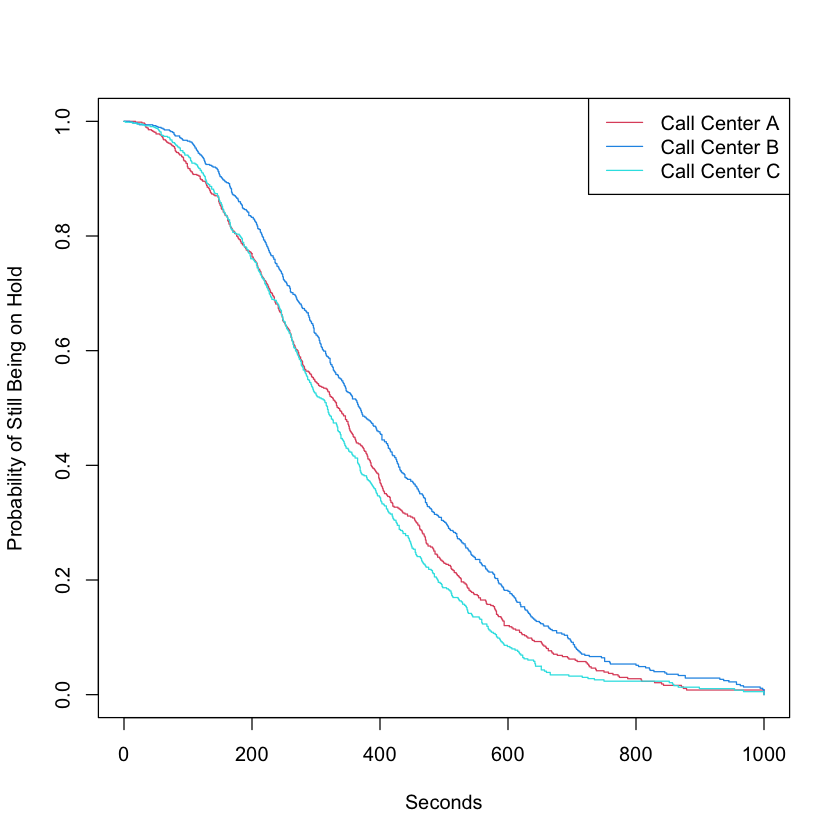

In [21]:
fit.Center <- survfit(Surv(y, failed) ~ Center,
    data = queuing$data)
plot(fit.Center, xlab = "Seconds",
    ylab = "Probability of Still Being on Hold",
    col = c(2, 4, 5))
legend("topright",
     c("Call Center A", "Call Center B", "Call Center C"),
     col = c(2, 4, 5), lty = 1)

Next, we stratify by `Time`.

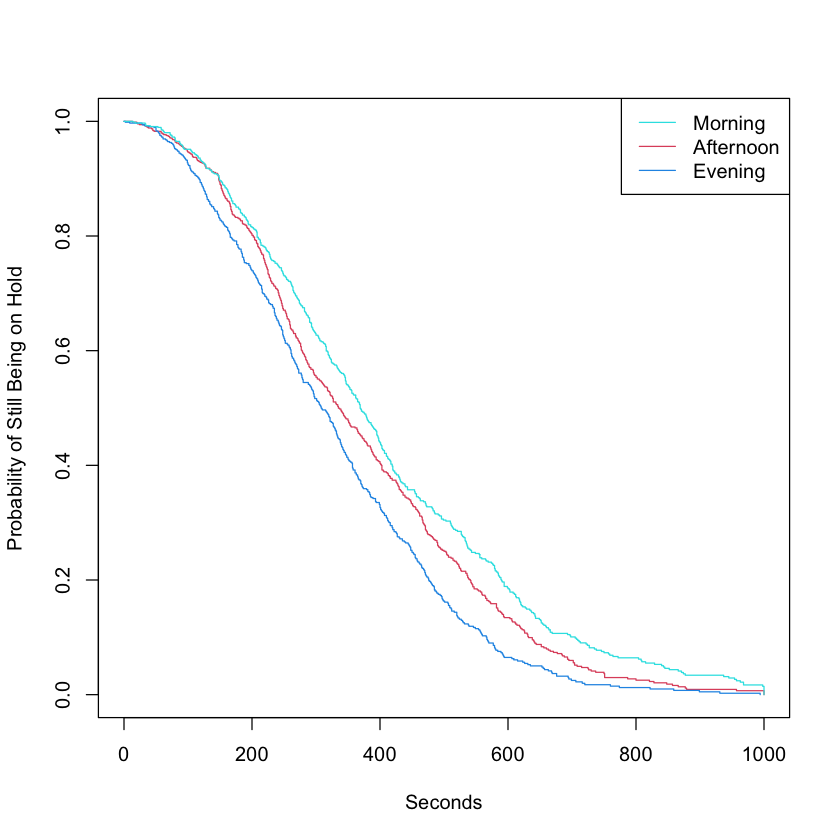

In [22]:
fit.Time <- survfit(Surv(y, failed) ~ Time,
   data = queuing$data)
plot(fit.Time, xlab = "Seconds",
    ylab = "Probability of Still Being on Hold",
    col = c(2, 4, 5))
legend("topright", c("Morning", "Afternoon", "Evening"),
    col = c(5, 2, 4), lty = 1)

It seems that calls at Call Center B
  take longer to be answered than calls at Centers A and C. Similarly, it appears that wait times are longest in the morning and shortest in the evening hours. We can use a log-rank test to determine whether these differences are statistically significant.

In [23]:
survdiff(Surv(y, failed) ~ Center, data = queuing$data)
survdiff(Surv(y, failed) ~ Time, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Center, data = queuing$data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
Center=A 683      603      579     0.971      1.45
Center=B 667      600      701    14.641     24.64
Center=C 650      577      499    12.062     17.05

 Chisq= 28.3  on 2 degrees of freedom, p= 7e-07 

Call:
survdiff(formula = Surv(y, failed) ~ Time, data = queuing$data)

              N Observed Expected (O-E)^2/E (O-E)^2/V
Time=After. 688      616      619    0.0135     0.021
Time=Even.  653      582      468   27.6353    38.353
Time=Morn.  659      582      693   17.7381    29.893

 Chisq= 46.8  on 2 degrees of freedom, p= 7e-11 

We find that  differences between centers are highly significant, as are differences between times of day.

Finally, we fit Cox's proportional hazards model to the data.

In [24]:
fit.queuing <- coxph(Surv(y, failed) ~ .,
    data = queuing$data)
fit.queuing

Call:
coxph(formula = Surv(y, failed) ~ ., data = queuing$data)

              coef exp(coef) se(coef)      z        p
Operators  0.04174   1.04263  0.00759  5.500  3.8e-08
CenterB   -0.21879   0.80349  0.05793 -3.777 0.000159
CenterC    0.07930   1.08253  0.05850  1.356 0.175256
TimeEven.  0.20904   1.23249  0.05820  3.592 0.000328
TimeMorn. -0.17352   0.84070  0.05811 -2.986 0.002828

Likelihood ratio test=102.8  on 5 df, p=< 2.2e-16
n= 2000, number of events= 1780 

The $p$-values for `Center = B`, `Time = Even.` and `Time = Morn.` are very small. It is also clear that the hazard --- that is, the instantaneous risk that a call will be answered --- increases with the number of operators. Since we generated the data ourselves, we know that the true coefficients for `Operators`, `Center = B`, `Center = C`, `Time = Even.` and `Time = Morn.` are  $0.04$, $-0.3$, $0$, $0.2$, and $-0.2$, respectively. The coefficient estimates resulting from the Cox model are fairly accurate.



